# Credit Card Fraud Model Build

This notebook explores **building the fraud detection model**.
This model will learn what "normal" transactions are like, and will judge whether a new transaction is different enough from a "normal" one that we should consider it fraudulent.

The following work will look fairly standard to anyone having trained machine learning models using python Jupyter notebooks.
The CML platform provides a **fully capable Jupyter notebook environment** that data scientists know and love.

In this part, you will learn how to train ML models using pandas and both scikit-learn's OneClassSVM and an autoencoder using Pytorch. For more detailed information on that approaches used here, please see Cloudera Fast Forward's [Deep Learning for Anomaly Detection](https://ff12.fastforwardlabs.com/) report.

If you haven't yet, run through the initialization steps in the README file and Part 1. 
In Part 1, the data is imported into the `default.cc_data` table in Hive. 
All data accesses fetch from Hive.

We will use the Kaggle [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) dataset here. The datasets contains transactions made by credit cards in September 2013 by European cardholders, and presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

The dataset should be uploaded to hive in the step 1. We will first load it as a Pandas DataFrame via Spark, and check the number of positive and negative samples.

In [6]:
from pyspark.sql import SparkSession

spark = SparkSession\
    .builder\
    .appName("PythonSQL")\
    .master("local[*]")\
    .getOrCreate()

try:
    spark_df = spark.sql("SELECT * FROM default.cc_data")
    spark_df.printSchema()
    data = spark_df.toPandas()
except:
    data = pd.read_csv("/home/cdsw/data/creditcardfraud.zip")

root
 |-- Time: decimal(10,0) (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double

In [7]:
print('Number of records:',len(data))
print('Positive samples:',len(data[data.Class==0]))
print('Negative samples:',len(data[data.Class==1]))

Number of records: 284807
Positive samples: 284315
Negative samples: 492


The dataset contains only numerical input variables which are the result of a PCA transformation. Features V1, V2, … V28 are the principal components obtained using a PCA process, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, and the feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [8]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Data Preprocessing
### Choosing positive samples

The next step is to munge the data for later steps. 
As we saw, this dataset has already been preprocessed to be very clean, and entirely numeric.
The only column that needs cleaning is `Class`.
For anomaly detection, scikit-learn marks inliers as `1`, and outliers as `-1`,
whereas this dataset has marked them `0` and `1`, respectively. 

In [9]:
data['Class'] = data['Class'].replace({0: 1, 1: -1})

The autoencoder for fraud detection uses only the positive (non-fraud) samples to train the model, thus only chooses records with Class==0. Then we split the chosen records as train set and test set.

In [10]:
in_class_set = data[data.Class==1]
out_class_set = data[data.Class==-1]
print('In class training set:',len(in_class_set))

In class training set: 284315


# One Class SVM Model

While the main model used in this project is a deep learning model, there are other techniques that can be used for anomaly detection. Here we show how to use a scikit-learn OneClassSVM.

This step follows a fairly standard ML workflow. Here, we:
- normalize the numeric features
- split into *test* and *train* sets
- train a classification model using these processed features
- evaluate the model's performance.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import OneClassSVM

For anomaly detection, we train the model *only* on inliers so it learns what normal data look like.
We then test on both inliers and outliers, so splitting the *test* and *train* sets will be slightly different.

In [12]:
# test/train split
X_train, X_test, y_train, y_test = train_test_split(in_class_set.drop('Class', axis=1),
                                                     in_class_set['Class'],
                                                     test_size=len(out_class_set),  # balanced test set
                                                     random_state=42)
# add outliers to test set
X_test = X_test.append(out_class_set.drop('Class', axis=1))
y_test = y_test.append(out_class_set['Class'])

In [13]:
# scale features based on test set
scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
# train one-class SVM
clf = OneClassSVM(gamma=0.5, nu=0.01, verbose=True)
clf.fit(X_train)

[LibSVM]

OneClassSVM(gamma=0.5, nu=0.01, verbose=True)

In [15]:
# evaluate one-class SVM
print('train accuracy:', accuracy_score(y_train, clf.predict(X_train)))
print('test accuracy:', accuracy_score(y_test, clf.predict(X_test)))
print(classification_report(y_test, clf.predict(X_test)))

train accuracy: 0.9900008103642058
test accuracy: 0.8404471544715447
              precision    recall  f1-score   support

          -1       0.99      0.69      0.81       492
           1       0.76      0.99      0.86       492

    accuracy                           0.84       984
   macro avg       0.87      0.84      0.84       984
weighted avg       0.87      0.84      0.84       984



In [16]:
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot as plt

ocsvm_auc = roc_auc_score(y_test, clf.score_samples(X_test))
fpr, tpr, _ = roc_curve(y_test, clf.score_samples(X_test))
plt.plot(fpr, tpr, label='OCSVM')
plt.title('OCSVM: AUROC=%.3f' % (ocsvm_auc))
plt.ylabel('true positive rate')
plt.xlabel('false positive rate')
plt.show()

## Deep Learning Model

This section shows how we can train a deep learning model using pytorch.

In [17]:
from datetime import datetime
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

### Data Preprocessing

When training the model, we will use the full dataset and not a balanced set like we did for the OneClassSVM.

In [18]:
from sklearn.model_selection import train_test_split
feature_names=data.columns.values[:-1]
train_test_set = in_class_set[feature_names]
train_set, test_set = train_test_split(train_test_set, test_size=0.2, random_state=42)

In [19]:
scaler=MinMaxScaler().fit(train_set)
train_set=scaler.transform(train_set)
test_set=scaler.transform(test_set)
train_set[:2]

array([[8.42327013e-01, 9.47416596e-01, 7.97217483e-01, 8.81816356e-01,
        2.41740662e-01, 5.43571003e-01, 5.15661441e-01, 4.19171267e-01,
        8.02040109e-01, 4.16891659e-01, 4.47903682e-01, 2.35464057e-01,
        6.15377573e-01, 4.10107015e-01, 5.23937212e-01, 4.48405051e-01,
        6.02247154e-01, 6.71423155e-01, 6.12703253e-01, 5.13449227e-01,
        4.11165178e-01, 6.10928994e-01, 5.39959714e-01, 6.67924552e-01,
        5.06573308e-01, 5.33984885e-01, 5.03033612e-01, 4.65364700e-01,
        2.22235356e-01, 5.09856012e-03],
       [2.44658194e-01, 9.79156142e-01, 7.97062325e-01, 8.90512717e-01,
        3.03888114e-01, 5.48372609e-01, 5.15350500e-01, 4.21609233e-01,
        7.95745386e-01, 3.66345976e-01, 4.95729107e-01, 3.75257082e-01,
        6.96864586e-01, 5.41487510e-01, 5.84645532e-01, 3.64243237e-01,
        5.45108394e-01, 6.30551391e-01, 5.31712561e-01, 5.85659779e-01,
        4.13125001e-01, 6.06201154e-01, 5.15266633e-01, 6.62486089e-01,
        4.14903779e-01,

We can also check the distribution of each feature. The following diagram shows the distribution of the first 4 features.

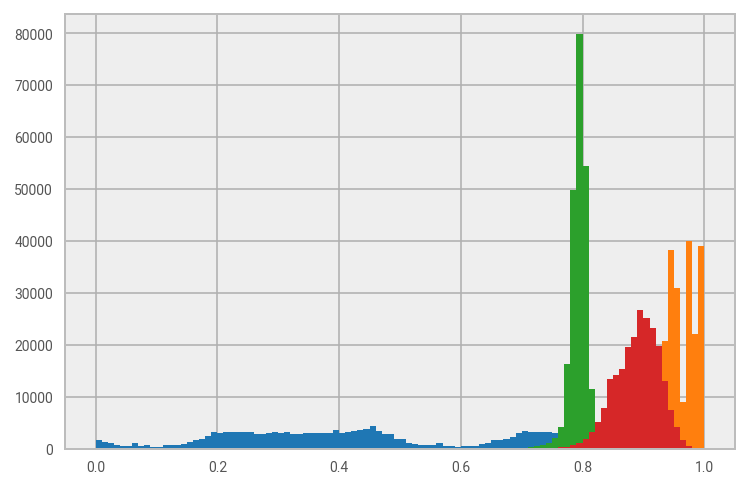

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
pd.Series(train_set[:,0]).hist(bins=100)
pd.Series(train_set[:,1]).hist(bins=100)
pd.Series(train_set[:,2]).hist(bins=100)
pd.Series(train_set[:,3]).hist(bins=100)

### Model Definition

Here we define the autoencoder model for PyTorch. There are 2 hidden layers each for the encoder and decoder, with 15 and 7 cells respectively, and ReLU is used as the activation function.

In [21]:
class autoencoder(nn.Module):
    def __init__(self,num_input):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num_input, 15),
            nn.ReLU(True),
            nn.Linear(15, 7))
        self.decoder = nn.Sequential(
            nn.Linear(7, 15),
            nn.ReLU(True),
            nn.Linear(15, num_input),
            nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Define the dataloader

To make this process work with both CPU and GPU sessions, the GPU specific requirements are put after a `if torch.cuda.is_available():` check.

In [22]:
batch_size = 256

# pytorch parallelism does not work as expected when using GPU.
if torch.cuda.is_available():
    num_workers = 4
else:
    num_workers = 0

inputs = torch.tensor(train_set, dtype=torch.float32)
dataset = TensorDataset(inputs)
dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

### Define loss function and optimizer

In [23]:
lr = 0.01

model = autoencoder(inputs.shape[1])
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

if torch.cuda.is_available():
    model.to('cuda') 
    criterion.to('cuda')
    inputs.to('cuda')

### Defining test function

The test function is used for cross validation during the training. Here we choose to do cross validation for each 5 epochs.

In [24]:
def test():
    model.eval()
    with torch.no_grad():
        tests_=torch.tensor(test_set, dtype=torch.float32)
        if torch.cuda.is_available():
            tests_.to('cuda')
        outputs = model(tests_)
        loss=criterion(outputs,tests_)
    return loss.item()/(tests_.shape[0]*tests_.shape[1])

### Model training

In [25]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    loss_sum=0.0; num=0
    for inputs, in dataloader:
        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        loss_sum+=loss.item()
        num+=(inputs.shape[0]*inputs.shape[1])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1)%5 == 0:
        print('{} epoch [{}/{}], loss:{:.6f}, test_set_loss:{:.6f}'
                .format(datetime.now(), epoch + 1, num_epochs, loss_sum/num, test()))

2020-07-14 10:00:43.743835 epoch [5/100], loss:0.001049, test_set_loss:0.001054
2020-07-14 10:00:55.904853 epoch [10/100], loss:0.001014, test_set_loss:0.001035
2020-07-14 10:01:08.707484 epoch [15/100], loss:0.000975, test_set_loss:0.000989
2020-07-14 10:01:20.207972 epoch [20/100], loss:0.000969, test_set_loss:0.000973
2020-07-14 10:01:33.647457 epoch [25/100], loss:0.000951, test_set_loss:0.000953
2020-07-14 10:01:47.955458 epoch [30/100], loss:0.000947, test_set_loss:0.000944
2020-07-14 10:02:00.167221 epoch [35/100], loss:0.000940, test_set_loss:0.000942
2020-07-14 10:02:12.153231 epoch [40/100], loss:0.001428, test_set_loss:0.001558
2020-07-14 10:02:26.195039 epoch [45/100], loss:0.001036, test_set_loss:0.001032
2020-07-14 10:02:40.383655 epoch [50/100], loss:0.000969, test_set_loss:0.000964
2020-07-14 10:02:53.045303 epoch [55/100], loss:0.000963, test_set_loss:0.000963
2020-07-14 10:03:04.511626 epoch [60/100], loss:0.000962, test_set_loss:0.000974
2020-07-14 10:03:17.804840 ep

## Model Evaluation

To evaluation the predictive capability of the trained model, we do the following:

* Preprocess the records using the MinMaxScaler (the *scaler* variable)
* Use the preprocessed data as the input vectors of the model, and compute the output vectors by feed forward.
* Calculate the root square of the input and output vectors, i.e. the generation losses.
* For those generation losses that are greater than a predefined threshold, we score them as *fraud*; otherwise, score as *normal*.

The value of the threshold is calculated via the distribution of the generation losses. First lets show the generation losses of the trained model for the *normal* and *fraud* cases.

### Distribution of generation losses

As the dataset is highly unbalanced, we take the whole positive (fraud) records while randomly choosing the equal number of negative (normal) records. The diagram below shows the results.

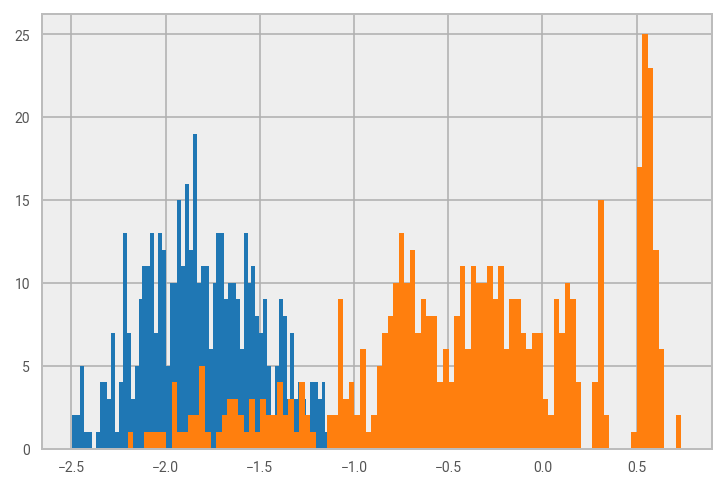

In [32]:
model.eval()

with torch.no_grad():
    test_set2 = data[data.Class==-1][feature_names]
    test_set2=scaler.transform(test_set2)
    inputs2=torch.tensor(test_set2, dtype=torch.float32)
    if torch.cuda.is_available():
        inputs2.to('cuda')
    outputs2=model(inputs2)
    loss2=torch.sum((inputs2-outputs2)**2,dim=1).sqrt().log()

    test_set1=test_set[np.random.choice(len(test_set),size=len(loss2),replace=False)]
    inputs1=torch.tensor(test_set1, dtype=torch.float32)
    if torch.cuda.is_available():
        inputs1.to('cuda')
    outputs1=model(inputs1)
    loss1=torch.sum((inputs1-outputs1)**2,dim=1).sqrt().log()

    pd.Series(loss1.numpy()).hist(bins=100)
    pd.Series(loss2.numpy()).hist(bins=100)

### Calculation of threshold (*split point*)

If the distribution functions of the generation losses are the convex function, the threshold is very easy to calculation. It is the just the intersection of the positive-case and negative-case distribution functions. However, as we see from the diagram above, neither of the distribution function is strictly convex.

Here, we define the threshold as the split point that maximize the average precise in both positive and negative cases. And use a *5-points* heuristic search approach to find the split point (see the **find_split_point** function).

Initially, we define the search range as the minimum generation loss of the positive cases and the maximum of the negative cases. For each iteration, we pick up half of the search range using the heuristic function to evaluate the picked range contains the split point. When the search range is smaller than 0.01, the iterations stop.

In [27]:
def precise_rate(split_point):
    rate1=(loss1<split_point).sum().item()/float(len(loss1))
    rate2=(loss2>split_point).sum().item()/float(len(loss2))
    return (rate1+rate2)/2            

def find_split_point(start,end,start_precise,end_precise):
    print(start,'->',end)
    delta=(end-start)/4.0
    precise=[start_precise]
    precise+=[precise_rate(start+i*delta) for i in range(1,4)]
    precise+=[end_precise]

    i = 0 if sum(precise[0:3])>sum(precise[1:4]) else 1
    j = i if sum(precise[i:i+3])>sum(precise[2:5]) else 2

    if end-start>0.01:
        return find_split_point(start+j*delta,start+(j+2)*delta,precise[j],precise[j+2])
    else:
        return start+delta*np.argmax(precise)


(start,end)=(loss1.max().item(),loss2.min().item())
(start,end)=(start,end) if start<end else (end,start)
split_point=find_split_point(start,end,precise_rate(start),precise_rate(end))
print('\nSplit point:',split_point)

-2.201681137084961 -> -0.4309435188770294
-1.3163123279809952 -> -0.4309435188770294
-1.3163123279809952 -> -0.8736279234290123
-1.2056412268429995 -> -0.984299024567008
-1.1503056762740016 -> -1.0396345751360059
-1.1503056762740016 -> -1.0949701257050037
-1.1226379009895027 -> -1.0949701257050037
-1.1088040133472532 -> -1.0949701257050037
-1.1018870695261285 -> -1.0949701257050037

Split point: -1.096699361660285


From the outputs above, we can see how the search range shrinks with each iterations, and the final split point calculated.

### Model precision rate

In [30]:
precise1=(loss1<split_point).sum().item()/float(len(loss1))
precise2=(loss2>split_point).sum().item()/float(len(loss2))

print('Precision rate for normal cases:',precise1)
print('Precision rate for fraud cases:',precise2)
print('Overall precision:',(precise1+precise2)/2)

Precision rate for normal cases: 0.9735772357723578
Precision rate for fraud cases: 0.8719512195121951
Overall precision: 0.9227642276422765


### Saving model

In [31]:
#torch.save(model.state_dict(), 'creditcard-fraud-2.model')